**Please trust the notebook to view the visualizations.**

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B: Advanced Topics in Data Science 

##  Measuring the Shape and Brightness of Galaxies with Neural Networks

### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University, Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>
**Project Advisors**: Douglas Finkbeiner and Jun Yin<br/>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load helper functions of secondary importance
%run utilities.ipynb

# Do not rerun training in the report
train = False

In [2]:
# Configure matplotlib format, dimensions and styling
%config InlineBackend.figure_formats = ['svg']
plt.rc("figure", figsize=(7, 3.5))
sns.set(style="white", palette=None, rc={"axes.linewidth": 1})
plt.rc("image", cmap="viridis")

# Outline

1. Problem Statement
2. Related Work
3. Data Generation
4. Exploratory Data Analysis
5. Model Building
6. Evaluation
7. Future Work
8. References

# Problem Statement

**Vast amounts of data:** As astronomers collect more and more image data, there is a need for further development of automated, reliable and fast analysis methods.

**Traditional methods:** For example, to describe a galaxy, software is used to fit a parametric or a non-parametric model and estimate the galaxy's brightness, shape, size and orientation. A commonly used, though not a perfect model, is the [Sérsic profile](https://en.wikipedia.org/wiki/Sersic_profile), developed in 1963.

**New methods:** In recent years, researchers have started exploring the application of deep learning methods to analyse astronomical data. For instance, classification of galaxies using CNNs has demonstrated high levels of accuracy. In this work we study the possibility to use neural networks to estimate galaxy parameters from simulated data.

Our **objective**: *Explore deep neural network architectures to estimate galaxy parameters from simulated data.*

# Related Work

*[To be written]*

# Data Generation

We use [GalSim](https://github.com/GalSim-developers/GalSim), an open source library, to generate the images of galaxies, following these steps:

1. **Sérsic profile:** Define a galaxy's Sérsic profile parametrized by the Sérsic index and the radius that encloses a half of the total flux
2. **Flux & shear:** Add flux and shear (defined by ellipticity and orientation) to complete the galaxy definition
3. **PSF:** Convolve the galaxy profile with the Point Spread Function, which is determined by the telescope optics and the atmosphere (for ground-based telescopes).
4. **Noise:** Add Poisson noise (e.g. detected photoelectrons) and Gaussian noise (e.g. read noise) to the generated the image
5. **Signal-to-noise ratio:** Compute the signal-to-noise ratio (SNR) based on the pixel values and the noise level (assuming faint galaxies):
$$
SNR = \frac{1}{\sigma_p} \sqrt{\sum p_i^2}
$$
   We preserve only the images with SNR between 10 and 100.
   

**Datasets:** We generate three datasets with increasing complexity for parameter estimation:
  
| Dataset | Number of Samples | PSF             | Gaussian Noise Level | Signal-to-Noise Ratio |
| ------- | ----------------- | --------------- | -------------------- | --------------------- |
| 1.      | 200,000           | 0.5             | 200                  | From 10 to 100        |
| 2.      | 200,000           | 0.5             | From 200 to 400      | From 10 to 100        |
| 3.      | 200,000           | From 0.5 to 1.0 | From 200 to 400      | From 10 to 100        |
  
**Number of samples:** We simulate 200,000 observation in total, using 180,000 samples for training and 20,000 for validation. Our choice to generate a large number of samples is driven by literature review, e.g. [Tuccillo, 2017](https://arxiv.org/pdf/1711.03108) and [Madireddy, 2019](https://arxiv.org/pdf/1911.03867), who are using 55,000 and 120,000 images respectively and suggest scaling up to 1 million. Our subsequent observations confirm that even on synthetic data, model performance improves as we add more data.

**Discretization:** One major challenge in simulating a large number of observations has to do with GalSim, which is relatively slow especially when generating images with higher Sérsic indices. The developers of GalSim [recommend](http://galsim-developers.github.io/GalSim/_build/html/gal.html#sersic-profile) considering the use of only discrete values of the Sérsic index for large simulations. This takes advantage of internal caching mechanisms and speeds up generation considerably. We follow that advice, discretize Sérsic index into 1,000 equally spaced values and [increase GalSim's cache size](https://github.com/dvukolov/GalSim/tree/sersic-cache). This cuts down CPU time for data generation from approximately 90 hours to 1.2 hours per dataset.

**Target variables:** Our goal is to estimate the following five parameters from image data, which are recorded alongside the generated images:

- Sérsic profile: determined by the **Sérsic index** and the **Sérsic radius**
- Galaxy **flux**
- Reparameterized **ellipticity and orientation**: $g_1$ and $g_2$

**Source code:** The code for data generation is based on the template provided by the module leaders and is available in the [GitHub repo](https://github.com/dvukolov/cs109b-project/blob/master/data/generator.py).

# Exploratory Data Analysis

**Milestone 2 EDA:** The majority of EDA has been carried out for Project Milestone 2 and is available in the corresponding [notebook](https://github.com/dvukolov/cs109b-project/blob/master/EDA/EDA.ipynb). We avoid repeating the analysis in the current report and instead refer the reader to the original document. Here we present only the findings that informed our model building approach. 

*[FIXME: The linked notebook is currently not displaying properly in the GitHub viewer due to custom HTML formatting]*

**Interactive app:** As part of the analysis we created an interactive [web app](https://measure-galaxies.herokuapp.com/) that laid the foundation for understanding the data. We used it throughout our project to study the relationship between galaxy parameters and the resulting images. It also helped us identify which parameter combinations could present a particular issue for the model versus which would be relatively easier to estimate.

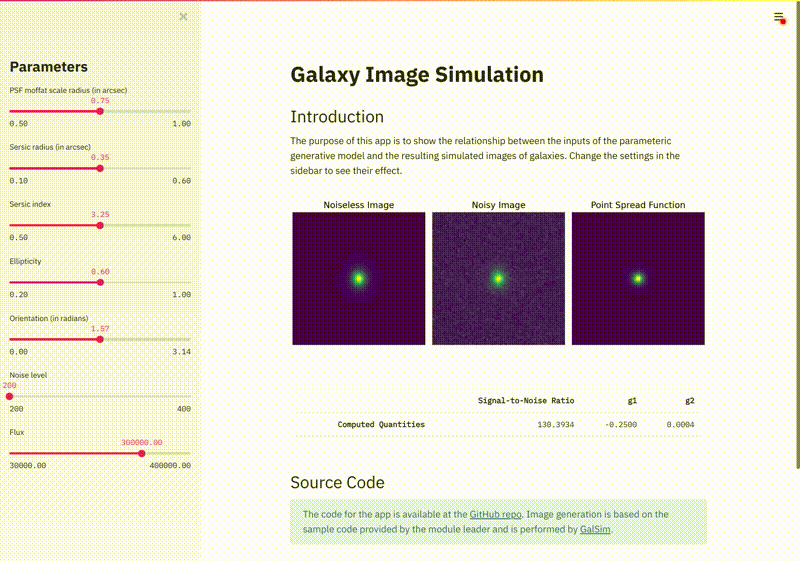

## Key Findings

*[FIXME: Rewrite our understanding of the parameters below very briefly]*

* **Low PSF** means the **light is concentrated** and its easier to spot the galaxy; **as the PSF rises the light is more spread out** and becomes harder to distinguish from the background. PSF is the **function of the telescope lens**.
* **Sersic Radius** works in a similar manner to PSF; **low Sersic Radius means concentrated light** and a galaxy that is easier to distinguish from the background noise.
* **Sersic Index** gives the **intensity of the galaxy**; the higher the Sersic Index the more intense the light from the galaxy and easier it is to spot it.
* **Ellipticity** describes the **shape of the galaxy** i.e. spherical vs elliptical.
* **Orientation** describes the **angles** at which the galaxy is oriented in the image.
* **Flux** describes the **brightness of the galaxy** - it is easier to spot the shape and location of a galaxy with high flux.
* As the **noise** content of the image increases, the more **blurry** the galaxy's shape becomes.

## Considerations for Model Building

The knowledge of the data-generating procedure, together with the EDA informed our subsequent model building as follows:

- The **Sérsic index** is **very difficult to estimate** making it an important parameter when doing model selection.
- The **target variables** need to be **rescaled** so that the loss is not driven by the variables with the largest magnitude.
- The **simulated images** form a perfect dataset, free of outliers and irregularities, with underlying **deterministic relationships between a handful of parameters**. Smaller neural networks might be capable of capturing the non-linear dependencies in the data, and **regularization might turn out to be optional**.
- The **PSF** and the **noise** levels **have a significant effect** on the obtained images. To understand how dramatic that effect is, we chose to establish an upper bound on model performance by training on the noiseless images first.**

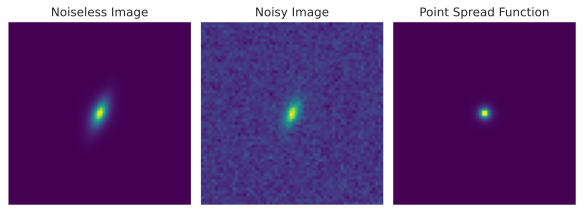

In [7]:
# Load the data with fixed PSF=0.5 and varying nose levels
dataset = "../data/data_v2.npz"
with np.load(dataset) as data:
    img = data["img"]
    img_nonoise = data["img_nonoise"]
    psf_img = data["psf_img"]
    label = data["label"]
    snr = data["snr"]

# Visualize one observation
idx = 3
images = img_nonoise[idx], img[idx], psf_img[0]
titles = ["Noiseless Image", "Noisy Image", "Point Spread Function"]

fig, axes = plt.subplots(1, 3, figsize=(8, 3.5), constrained_layout=True)
for image, title, ax in zip(images, titles, axes):
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(title)

# Model Building

In our model building we used multiple approaches:

**Autoencoders**: Knowing that the module leaders have been working on a conditional AE, we come up with and evaluate several possibly related architectures.

<img style="float: right; padding-left: 10px; padding-bottom: 20px;" src="https://autokeras.com/img/row_red.svg" width="200" /> **Neural architecture search:** Using a small subset of the data we run AutoKeras, an AutoML tool, to quickly test vanilla CNNs, ResNets and Xception networks with different complexities, regularization and normalization parameters. The search is guided by Bayesian optimization with Gaussian Processes.

**Grid search**: We pick several key hyperparameters of the best model, expand their range and evaluate the effect using a small portion of the data. This allows to significantly reduce the model size while simultaneously maintaining or even improving predictive performance.

**Reproducing from literature:** Informed by a large gap between performance metrics for noiseless and noisy data, we test a two-stage pipeline described in [Madireddy (2019)](https://arxiv.org/pdf/1911.03867) that uses a separate denoising network as the first step. 

# Autoencoder

*[To be written]*

# Neural Architecture Search

We perform initial neural architecture search with the help of [AutoKeras](https://autokeras.com/), an AutoML tool from the Keras team. On a small subset of the dataset:

- We test different **type of architectures**: regular CNNs, ResNets and Xception models
- Vary the **specifics of the architectures**: depth and the width of the network, the convolutional kernel size, striding, type of pooling, different activation functions
- We test whether data **normalization** and **dropout** regularization are necessary
- As well as briefly check the effect of three **optimizers**: Adam, Adagrad and SGD

Our hypothesis is that due to the simulated and homogeneous nature of the dataset, the performance on a small subset will be indicative of the performance on the full dataset.

In [11]:
import json
import autokeras as ak
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Use unscaled images. Let Autokeras figure out if normalization is needed.
subset = 20_000
X = img[:subset]

# Scale the labels between -1 and 1 using the full dataset, since we know the ranges of generated labels.
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(label[:subset])

if train:
    # Define and train an AutoKeras model
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    input_node = ak.ImageInput()
    output_node = ak.ImageBlock(augment=False)(input_node)
    output_node = ak.RegressionHead()(output_node)
    auto = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=100, tuner="bayesian")
    auto.fit(X, y, epochs=100, validation_split=0.2, verbose=2, callbacks=[early_stopping])

    # Instantiate the best model
    model = auto.export_model()
    
    # Save best hyperparameters
    hp = auto.tuner.get_best_hyperparameters()[0]
    params = hp.get_config()['values']
    json_path = "../experiments/autokeras/noisy_params.json"
    with open(path, "wt") as f:
        json.dump(params, f, indent=2)

The output of the search demonstrates that:

- **ResNets** perform significantly worse on our data compared to **regular CNNs** and **Xception** models
- Normalization and specifically **standardization** of the images to zero mean and standard deviation of one is beneficial
- **Dropout** is generally unnecessary, as it negatively impacts predictive performance and increases the training time
- **Adam** converges faster than the alternative optimizers and produces the lowest mean-squared error

The resulting best model chosen by AutoKeras has [Xception](https://arxiv.org/pdf/1610.02357.pdf) architecture with 8 residual blocks, 16 convolutional filters in the entry flow, 384 filters in the separable convolutions, a kernel size of 5, selu activation and global average pooling.

In [16]:
# Display the set of best hyperparameters chosen by AutoKeras
with open(json_path) as f:
    configuration = json.load(f)
configuration

{'image_block_1/xception_block_1/activation': 'selu',
 'image_block_1/xception_block_1/initial_strides': 2,
 'image_block_1/xception_block_1/num_residual_blocks': 8,
 'image_block_1/xception_block_1/pooling': 'avg',
 'image_block_1/xception_block_1/conv2d_num_filters': 16,
 'image_block_1/xception_block_1/kernel_size': 5,
 'image_block_1/xception_block_1/sep_num_filters': 384,
 'regression_head_1/dropout_rate': 0.0,
 'optimizer': 'adam'}

We implement this architecture in code and instantiate the model:

In [17]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from kerastuner.applications import xception


def build_xception_model(
    input_shape,
    output_shape,
    normalize=True,
    conv2d_num_filters=64,
    kernel_size=5,
    initial_strides=2,
    activation="selu",
    sep_num_filters=256,
    num_residual_blocks=4,
    pooling="avg",
    dropout_rate=0,
):
    """Build an image regression model with Xception blocks.
    Original architecture by François Chollet https://arxiv.org/pdf/1610.02357.pdf
    Code based on Autokeras and Keras Tuner.
    """

    assert len(input_shape) == 3, "The input images should have a channel dimension"
    assert activation in ["relu", "selu"]
    assert pooling in ["avg", "flatten", "max"]

    inputs = layers.Input(shape=input_shape)
    x = inputs

    if normalize:
        # Compute the mean and the variance of the dataset and store it as model weights.
        # Don't forget to use adapt_model(model, X) before fitting the model.
        x = preprocessing.Normalization()(x)

    # Initial conv2d
    x = xception.conv(
        x, conv2d_num_filters, kernel_size=kernel_size, activation=activation, strides=initial_strides
    )

    # Separable convolutions
    for _ in range(num_residual_blocks):
        x = xception.residual(x, sep_num_filters, activation=activation, max_pooling=False)

    # Exit flow
    x = xception.residual(x, 2 * sep_num_filters, activation=activation, max_pooling=True)

    pooling_layers = {
        "flatten": layers.Flatten,
        "avg": layers.GlobalAveragePooling2D,
        "max": layers.GlobalMaxPooling2D,
    }
    x = pooling_layers[pooling]()(x)

    # Regression head
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(output_shape[-1])(x)
    
    model = Model(inputs, outputs)
    return model

In [25]:
# Define the input and output shapes
input_shape = X[..., np.newaxis].shape[1:]
output_shape = y.shape[1:]

# Instantiate the model
model = build_xception_model(
    input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=384, num_residual_blocks=8,
)
print(f"The total number of parameters: {model.count_params():,}")

The total number of parameters: 3,479,224


# Grid Search

Like any tool AutoKeras is not perfect. We use it as a starting point to select one possible architecture that works reasonably well on our data. The resulting model is relatively large, containing around 3.5 mln parameters and trains slowly. In an effort to optimize the model further, we identify **two key hyperparameters** that determine model complexity the most, and run a **grid search** on them. We choose to keep the network quite **deep**, as selected by neural architecture search. This parameter does not influence the total number of parameters of Xception architecture significantly, while permitting it to capture highly non-linear relationships.

In [30]:
from pathlib import Path
from sklearn.model_selection import ParameterGrid

# Add a channel dimension to the input images
X = X[..., np.newaxis]

# Define a set of parameters to test
params = dict(conv2d_num_filters=[4, 8, 16, 32, 64, 128], sep_num_filters=[4, 8, 16, 32, 64, 128, 256, 384])
model_args = list(ParameterGrid(params))
total = len(model_args)
destination = "../experiments/gridsearch/trials-v1b"

# Perform grid search
for i, args in enumerate(model_args, start=1):
    cval, sval = args["conv2d_num_filters"], args["sep_num_filters"]
    filename = Path(destination) / f"trial-c{cval}-s{sval}.json"
    if filename.exists():
        continue
        
    print(f"Testing {i}/{total}: {args}")
    model = build_xception_model(input_shape, output_shape, num_residual_blocks=8, **args)
    model.compile(optimizer="adam", loss="mse")
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    # Adapt the normalization layer to the data
    adapt_model(model, X)
    history = model.fit(
        X,
        y,
        batch_size=32,
        epochs=100,
        validation_split=0.2,
        verbose=2,
        callbacks=[early_stopping],
    )
    
    doc = args.copy()
    doc['score'] = np.min(history.history["val_loss"])
    with open(filename, "w") as f:
        json.dump(doc, f)
    print()

We then interactively analyze the results of the grid search by slicing the data along each axis. Please see the help section of the tool on the various ways of using it:

In [35]:
import hiplot as hip

def fetch_trials(directory, pattern):
    """Retrieve the saved results of the grid search experiment"""
    p = Path(directory)
    results = []

    for file in p.rglob(pattern):
        if not file.is_file:
            continue
        with open(file) as f:
            trial = json.load(f)
            results.append(trial)
            
    return hip.Experiment.from_iterable(results)

# Please trust the notebook to see the results
fetch_trials(destination, "trial-*.json").display();

<IPython.core.display.Javascript object>

The performance of many Xception models is quite similar. Still, based on the visualization of the grid search, `sep_num_filters=64` produce low values of the loss with a very small variance. We combine it with a low number of filters in the initial convolutional layers `conv2d_num_filters=16` to obtain our best model. This ends up significantly reducing model complexity from 3.5 mln parameters to just over 109K, while at the same time improving performance and substantially cutting down the training time:

In [34]:
# Instantiate the best Xception model
model = build_xception_model(
    input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=64, num_residual_blocks=8,
)
print(f"The total number of parameters: {model.count_params():,}")

The total number of parameters: 109,304


Below we show an abbreviated version of the model's architecture with just two residual blocks for the sake of readability. The central section of two separable convolution blocks and the following addition is repeated six more times in the final model:

<img src="./graphs/Xception.png" width="500px">

# Model Training

We then proceed to training the model on the full dataset with 200,000 observations. We use 90% of the data for training and 10% for validation. To establish an upper bound on model performance, we first train the model on noiseless images. We then continue with noisy images from a dataset with a fixed level of Gaussian noise and then with varying Gaussian noise. The PSF for all these datasets is fixed at `PSF=0.5`:

In [55]:
# Define a set of experiments
experiments = [
    {
        "name": "Noiseless Images with fixed PSF",
        "image": "img_nonoise",
        "dataset": "../data/data_v1.npz",
        "modelpath": "../models/xception_data_v1_noiseless.tf",
        "scalerpath": "../models/xception_data_v1.scaler",
    },
    {
        "name": "Noisy Images with fixed PSF and Sigma",
        "image": "img",
        "dataset": "../data/data_v1.npz",
        "modelpath": "../models/xception_data_v1.tf",
        "scalerpath": "../models/xception_data_v1.scaler",
    },
    {
        "name": "Noisy Images with fixed PSF and varying Sigma",
        "image": "img",
        "dataset": "../data/data_v2.npz",
        "modelpath": "../models/xception_data_v2.tf",
        "scalerpath": "../models/xception_data_v2.scaler",
    },
]

In [56]:
label_names = ["Flux", "Sersic index", "Sersic radius", "g1", "g2"]
RMSE = []

# Setup callbacks
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

# Run the experiments
for experiment in experiments:
    # Load the data
    with np.load(experiment["dataset"]) as data:
        image = data[experiment["image"]]
        label = data["label"]

    # Define inputs and outputs
    X = image[..., np.newaxis]
    input_shape = X.shape[1:]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    y = scaler.fit_transform(label)
    output_shape = y.shape[1:]
    
    if train:
        # Build an Xception model
        model = build_xception_model(
            input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=64, num_residual_blocks=8,
        )
        model.compile(optimizer="adam", loss="mse")
        # Adapt the normalization layer to the data
        adapt_model(model, X)

        # Train the model
        history = model.fit(
            X,
            y,
            batch_size=32,
            epochs=1000,
            validation_split=0.1,
            verbose=2,
            callbacks=[early_stopping],
        )
        model.save(experiment["modelpath"])
        
        # Save the MinMax scaler to convert model outputs
        with open(experiment["scalerpath"], "wb") as f:
            pickle.dump(scaler, f)
    else:
        model = tf.keras.models.load_model(experiment["modelpath"])
        
    # Evaluate the model on the validation set
    n_train = int(label.shape[0] * 0.9)
    X_val = X[n_train:]
    label_val = label[n_train:]

    # Predict the labels and convert them to the original scale
    predictions = model.predict(X_val)
    predictions = scaler.inverse_transform(predictions)

    # Compute RMSE for each label individually
    rmse = np.sqrt(((label_val - predictions)**2).mean(axis=0))
    
    # Collect the results
    results = {"Experiment": experiment["name"]}
    results.update(dict(zip(label_names, rmse)))
    RMSE.append(results)

After training the models we print out the resulting RMSE for each of the target labels in their original units:

In [57]:
# Show RMSE for the target labels
pd.DataFrame(RMSE)

,Experiment,Flux,Sersic index,Sersic radius,g1,g2
0,Noiseless Images with fixed PSF,383.312195,0.029203,0.002238,0.004046,0.003601
1,Noisy Images with fixed PSF and Sigma,5913.239258,0.780093,0.046175,0.073667,0.073462
2,Noisy Images with fixed PSF and varying Sigma,8993.485352,0.835633,0.051174,0.083889,0.083067


# Denoising Pipeline

# Evaluation

# Limitations and Failure Modes

# Future Work

# References

1. A. W. Graham, S. P. Driver, 2005, [A concise reference to (projected) Sersic $R^{1/n}$ quantities, including Concentration, Profile Slopes, Petrosian indices, and Kron Magnitudes](https://arxiv.org/pdf/astro-ph/0503176)
2. D. Tuccillo, M. Huertas-Company, E. Decencière, S. Velasco-Forero, H. Domínguez Sánchez, P. Dimauro, 2017, [Deep learning for galaxy surface brightness profile fitting](https://arxiv.org/pdf/1711.03108)
3. S. Madireddy, N. Li, N. Ramachandra, P. Balaprakash, S. Habib, 2019, [Modular Deep Learning Analysis of Galaxy-Scale Strong Lensing Images](https://arxiv.org/pdf/1911.03867)
4. François Chollet, 2017, [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/pdf/1610.02357)
4. Peter Erwin, 2014, [Imfit: A Fast, Flexible New Program for Astronomical Image Fitting](https://arxiv.org/pdf/1408.1097)
5. I. Breda, P. Papaderos, J. M. Gomes, S. Amarantidis, 2019, [A new fitting concept for the robust determination of Sérsic model parameters](https://arxiv.org/pdf/1910.07043)
6. B. Lim, S. Son, H. Kim, S. Nah, K. M. Lee, 2017, [Enhanced Deep Residual Networks for Single Image Super-Resolution](https://arxiv.org/pdf/1707.02921)
7. Y. Zhang, Y. Tian, Y. Kong, B. Zhong, Y. Fu, 2020, [Residual Dense Network for Image Restoration](https://arxiv.org/pdf/1812.10477)